# Bayesian evidence estimation with normalizing flows

A prototype code that combines the Adaptive Harmonic Mean Integration algorithm with a simple spline-based normalizing flow algorithm.  

In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.integrate as integrate
import scipy.special as special
smoke_test = ('CI' in os.environ)

In [2]:
class GaussianShell():
    def __init__(self, r, w, n):
        self.r = r
        self.w = w
        self.n = n
        self.c = np.zeros(n)
        
        radial_integral = lambda ρ : ρ**(self.n-1)*np.exp(-(ρ - self.r )**2 / (2*self.w**2))
        density_norm = np.sqrt(2*np.pi*self.w**2)
        radial_norm = (np.sqrt(2)*np.pi**((self.n-1)/2)) / (special.gamma(self.n/2)*self.w)*integrate.quad(radial_integral, 0, self.r+self.w*20)[0]
    
        self.lognorm = np.log(density_norm) + np.log(radial_norm)
        
    def logpdf(self, x): 
        
        assert len(x) == self.n, "Wrong number of dimensions!"
        
        integral_result = -(np.sqrt(np.sum((x - self.c)**2)) - self.r)**2 / (2*self.w**2)
        result = integral_result - self.lognorm
        return result
    
    def rng(self, nsamples):
        
        pdf_run = lambda r_run : gs_pdf_r(r_run, self.n, self.r, self.w)
        
        r_samples = randomvariate(pdf_run, n=nsamples,xmin=0,xmax=100)
        
        ang_samples = np.random.randn(self.n,nsamples)
        ang_samples = ang_samples / np.sqrt(np.sum(ang_samples * ang_samples, 0))
        
        samples = ang_samples * r_samples
        
        return samples

In [3]:
class Mixture():
    def __init__(self, dist_list):
        
        self.dist_list = dist_list
        self.ndims = np.unique([i.n for i in dist_list])
        assert len(self.ndims) == 1, "Wrong number of dimensions!"
        self.ndist = len(dist_list)
        
    def logpdf(self, x): 
        
        assert len(x) == self.ndims, "Wrong number of dimensions!"
        return np.log(np.sum([np.exp(i.logpdf(x)) for i in self.dist_list]))
    
    def rng(self, nsamples):
        
        nsamples_tmp = nsamples // self.ndist 
        arrays = [i.rng(nsamples_tmp) for i in self.dist_list]
        arrays = np.concatenate(arrays, axis=1)
    
        return arrays[:, np.random.permutation(arrays.shape[1])]
        

In [4]:
def nball_surf_area(r, ndims):
    return 2 * np.pi**(ndims/2) / special.gamma(ndims/2) * r**(ndims-1)
    
def gs_pdf_r(r, ndims, r0, w):
    return nball_surf_area(r, ndims) * 1/(2*np.pi * w**2) * np.exp(-(np.abs(r) - r0)**2 / (2 * w**2)) 

def randomvariate(pdf,n=1000,xmin=0,xmax=1):  
    
    x=np.linspace(xmin,xmax,3000)  
    y=pdf(x)  
    
    pmin=0.  
    pmax=y.max()  

    naccept=0  
    ntrial=0  

    ran=np.array([])  
    while naccept<n:  
        x=np.random.uniform(xmin,xmax) # x'  
        y=np.random.uniform(pmin,pmax) # y'  

        if y<pdf(x):  
            ran = np.append(ran, x)  
            naccept=naccept+1  
        
        ntrial=ntrial+1    

    return ran  

In [5]:
d1 = GaussianShell(4,0.4,2)
d2 = GaussianShell(2,0.3,2)

dmixt = Mixture([d1, d2])

In [6]:
# f = lambda y, x: np.exp(dmixt.logpdf(np.array([x,y])))
# integrate.dblquad(f, -5, 5, lambda x: -5, lambda x: 5)

In [7]:
nsamples = 40000
samples = dmixt.rng(nsamples).T

In [8]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

ind_tmp = list(split(range(nsamples), 4))

samples_scaler = samples[ind_tmp[0],:]
samples_train = samples[ind_tmp[1],:]
samples_test = samples[ind_tmp[2],:]
samples_integrate = samples[ind_tmp[3],:]

In [9]:
scaler = StandardScaler()
scaler.fit(samples_scaler)

samples_train = scaler.transform(samples_train) 
samples_test = scaler.transform(samples_test) 
samples_integrate = scaler.transform(samples_integrate) 

In [10]:
def scaled_target(x):
    x = x.T * scaler.scale_
    x = x + scaler.mean_
    x = x.T
    return np.exp(dmixt.logpdf(x))*np.prod(scaler.scale_)

<ipython-input-11-29f923fc50b4>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(xv, yv, zi.reshape(xv.shape));


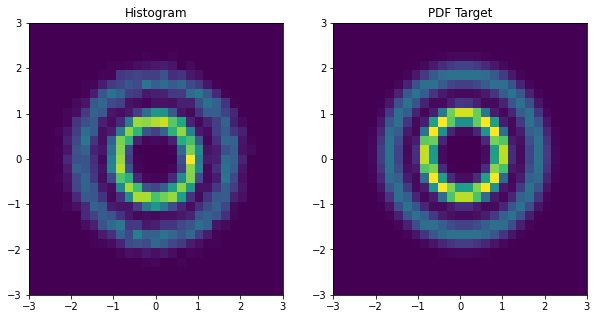

In [11]:
xrange = np.linspace(-3, 3, num=30)
yrange = np.linspace(-3, 3, num=30)

h, xedges, yedges = np.histogram2d(samples_test[:,0], samples_test[:,1], bins=[xrange, yrange], density=True) 

xv, yv = np.meshgrid(xrange, yrange)
tmp = np.vstack([xv.flatten(), yv.flatten()])
zi = np.apply_along_axis(scaled_target, 0, tmp)

fig, (ax, ax1) = plt.subplots(1,2, figsize=(10, 5))

# ax.hist2d(samples[:,0], samples[:,1], bins=40, cmap="Blues");
ax.set_title("Histogram");
ax1.set_title("PDF Target");

ax1.pcolormesh(xv, yv, zi.reshape(xv.shape));
ax.pcolormesh(xv, yv, h);

In [12]:
# Simple density integral: 
np.diff(xrange)[1]*np.diff(yrange)[1]*np.sum(zi)

1.999885558521864

In [13]:
# Quadrature density integral: 

f1 = lambda y, x: scaled_target(np.array([x,y]))
integrate.dblquad(f1, -5, 5, lambda x: -5, lambda x: 5)

(1.9999999999999978, 1.4066604986364046e-08)

$$Y\sim p_Y(y) $$
Assume that
$$X\sim p_X(x) = \mathcal{N}(x|0,1)$$
$$y=g(x)$$
Expectation values: 

\begin{align}
\mathbb{E}_{p_X(\cdot)}\left[f(X)\right] &= \int_{\text{supp}(X)}f(x)p_X(x)dx\\
&= \int_{\text{supp}(Y)}f(g^{-1}(y))p_X(g^{-1}(y))\left|\frac{dx}{dy}\right|dy\\
&= \mathbb{E}_{p_Y(\cdot)}\left[f(g^{-1}(Y))\right]
\end{align}

Density transformation: 
\begin{align}
\log(p_Y(y)) &= \log(p_X(g^{-1}(y)))+\log\left(\left|\frac{dx}{dy}\right|\right)\\
&= \log(p_X(g^{-1}(y)))-\log\left(\left|\frac{dy}{dx}\right|\right).
\end{align}

The spline coupling transformation layer: 


$$\mathbf{y}_{(d+1):D} = h_\phi(\mathbf{x}_{(d+1):D};\mathbf{x}_{1:d})$$

where $\mathbf{x}$ are the inputs, $\mathbf{y}$  are the outputs, e.g. $\mathbf{x}_{1:d}$ represents the first  elements of the inputs, $g_\theta$ is either the identity function or an elementwise rational monotonic spline with parameters $\theta$, and $h_\phi$ is a conditional elementwise spline spline, conditioning on the first $d$ elements.

In [14]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [15]:
steps = 1 if smoke_test else 3001
dataset_train = torch.tensor(samples_train, dtype=torch.float)
dataset_test = torch.tensor(samples_test, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss_train = -flow_dist.log_prob(dataset_train).mean()
    loss_train.backward()
    optimizer.step()
    flow_dist.clear_cache()
    loss_test = -flow_dist.log_prob(dataset_test).mean()
    flow_dist.clear_cache()
    if step % 500 == 0:
        print('step: {}, loss train: {}, loss test: {}'.format(step, loss_train.item(), loss_test.item()))

step: 0, loss train: 5.913058757781982, loss test: 5.777591228485107
step: 500, loss train: 2.32413387298584, loss test: 2.3405404090881348
step: 1000, loss train: 2.313833713531494, loss test: 2.3343749046325684
step: 1500, loss train: 2.2990660667419434, loss test: 2.330491781234741
step: 2000, loss train: 2.2883970737457275, loss test: 2.3198702335357666
step: 2500, loss train: 2.278522491455078, loss test: 2.3182077407836914
step: 3000, loss train: 2.302048444747925, loss test: 2.33264422416687


### Test transformation accuracy: 

In [16]:
X_flow = flow_dist.sample(torch.Size([nsamples//4,])).detach().numpy()

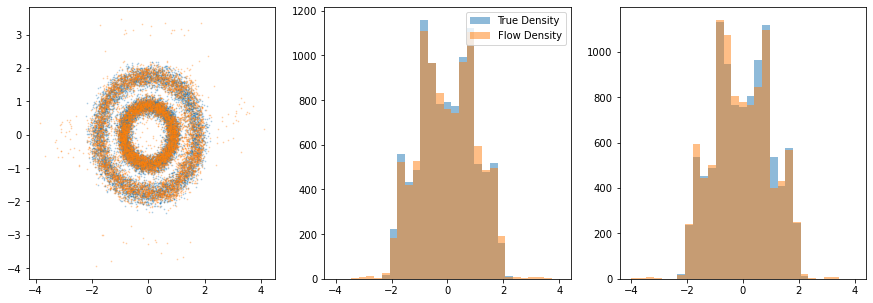

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].scatter(samples_test[:,0], samples_test[:,1], alpha=0.3, s=0.5, label="True Density");
ax[0].scatter(X_flow[:,0], X_flow[:,1], alpha=0.3, s=0.5, label="Flow Density");

ax[1].hist(samples_test[:,0], alpha=0.5, bins=np.linspace(-4, 4, 30), label="True Density");
ax[1].hist(X_flow[:,0],alpha=0.5, bins=np.linspace(-4, 4, 30), label="Flow Density");

ax[1].legend()

ax[2].hist(samples_test[:,1], alpha=0.5, bins=np.linspace(-4, 4, 30));
ax[2].hist(X_flow[:,1], alpha=0.5, bins=np.linspace(-4, 4, 30));

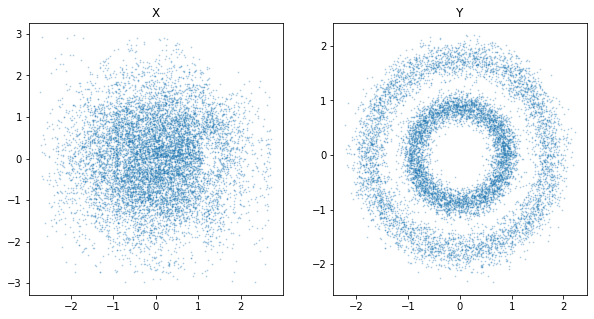

In [18]:
samples_test_inv = spline_transform.inv(torch.tensor(samples_test, dtype=torch.float)).detach().numpy()

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[1].scatter(samples_test[:,0], samples_test[:,1], alpha=0.3, s=0.5);
ax[1].set_title("Y");
ax[0].set_title("X");
ax[0].scatter(samples_test_inv[:,0], samples_test_inv[:,1], alpha=0.3, s=0.5);

In [19]:
def log_jac(x, y):
    return spline_transform.log_abs_det_jacobian(torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)).detach().numpy()   # dx / dy

def transformed_target(x1, x2):
    x = np.array([x1, x2])
    y = spline_transform(torch.tensor(x, dtype=torch.float)).detach().numpy()
    f_y = scaled_target(y)
    dy_dx = np.exp(log_jac(x, y))
    return f_y * dy_dx

<ipython-input-20-0e8879e5df59>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xv, yv, zi.reshape(xv.shape));


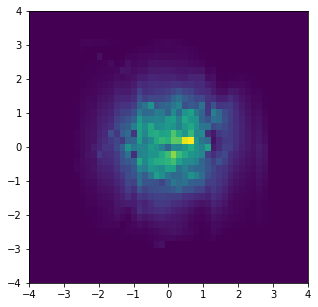

In [20]:
xrange = np.linspace(-4, 4, num=50)
yrange = np.linspace(-4, 4, num=40)

xv, yv = np.meshgrid(xrange, yrange)
tmp = np.vstack([xv.flatten(), yv.flatten()])
zi = np.apply_along_axis(lambda x: transformed_target(x[0], x[1]), 0, tmp)

fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.pcolormesh(xv, yv, zi.reshape(xv.shape));


In [21]:
# Integral is preserved: 
np.diff(xrange)[1]*np.diff(yrange)[1]*np.sum(zi)

2.017705642757994

### Harmonic mean estimate:

$$\mathbb{E}_{p_Y(\cdot)}\left[\frac{1}{f(Y)}\right] = \frac{\int_\Delta \frac{1}{f(y)}f(y) dy}{I_\Delta} = \frac{\int_\Delta dy}{I_\Delta} = \frac{V_\Delta}{I_\Delta}$$

Transformed space: 

$$\mathbb{E}_{p_X(\cdot)}\left[\frac{1}{f(g(X))}\right] = \frac{\int_\Delta \frac{1}{f(g(x))}f(g(x)) |\frac{dy}{dx}| dx}{I_\Delta} =\frac{\int_\Delta |\frac{dy}{dx}| dx}{I_\Delta} = \text{for linear transformation} = \frac{V_x}{|\frac{dx}{dy}| I_\Delta} $$

In [22]:
samples_integrate_inv = spline_transform.inv(torch.tensor(samples_integrate, dtype=torch.float)).detach().numpy()
dy_dx = np.array([np.exp(log_jac(samples_integrate_inv[i,:], samples_integrate[i,:])) for i in range(0, samples_integrate.shape[0])])
y_lik = np.apply_along_axis(scaled_target, 1, samples_integrate)
x_lik = y_lik * dy_dx

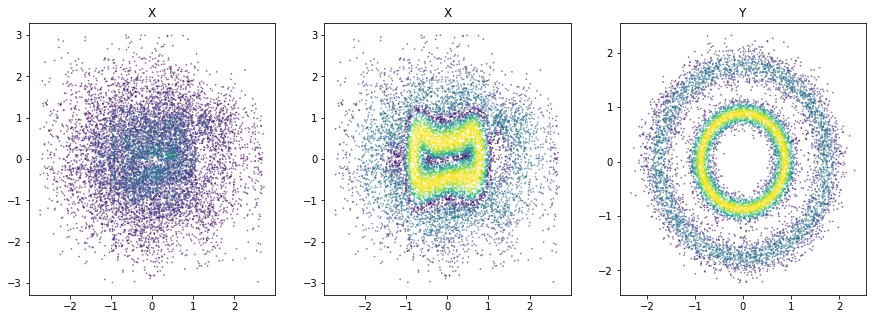

In [23]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

ax[0].scatter(samples_integrate_inv[:,0], samples_integrate_inv[:,1], c = x_lik, alpha=0.5, s=0.6)
ax[1].scatter(samples_integrate_inv[:,0], samples_integrate_inv[:,1], c = y_lik, alpha=0.5, s=0.6)
ax[2].scatter(samples_integrate[:,0], samples_integrate[:,1], c = y_lik, alpha=0.5, s=0.6)

ax[2].set_title("Y")
ax[0].set_title("X")
ax[1].set_title("X");

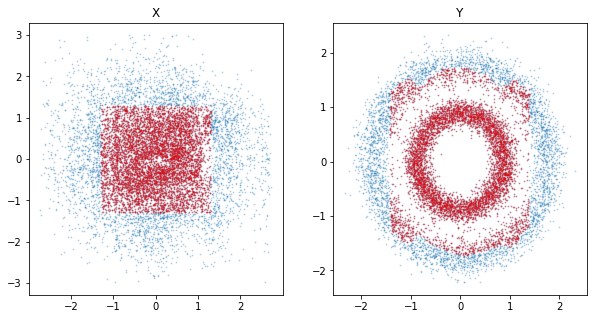

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[1].scatter(samples_integrate[:,0], samples_integrate[:,1], alpha=0.3, s=0.5);
ax[0].scatter(samples_integrate_inv[:,0], samples_integrate_inv[:,1], alpha=0.3, s=0.5);

s = 1.3
mask = np.array(np.prod(np.abs(samples_integrate_inv) < s, 1), dtype=bool)

ax[1].scatter(samples_integrate[mask,0], samples_integrate[mask,1], color="red", alpha=0.3, s=0.5);
ax[0].scatter(samples_integrate_inv[mask,0], samples_integrate_inv[mask,1], color="red", alpha=0.3, s=0.5);

ax[1].set_title("Y");
ax[0].set_title("X");

In [25]:
i = (2*s)**2 / np.mean(1/(x_lik[mask]))
i = i * mask.size / sum(mask)

In [26]:
i # Works! 

1.9893763627129948

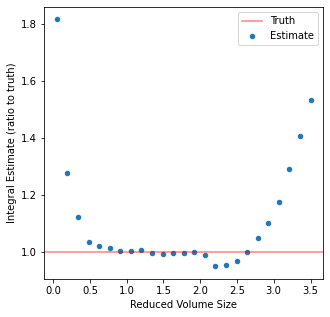

In [28]:
def est_integral(vsize, samples, lik_vals):
    mask = np.array(np.prod(np.abs(samples) < vsize, 1), dtype=bool)
    i = (2*vsize)**2 / np.mean(1/(lik_vals[mask]))
    return i * mask.size / sum(mask)

vsize_vals = np.linspace(0.05, 3.5, 25)
int_vals = [est_integral(i, samples_integrate_inv, x_lik)/2 for i in vsize_vals]


fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.axhline([1], color="red", alpha=0.5, label="Truth");
ax.scatter(vsize_vals, int_vals, s=20, label="Estimate")
ax.set_xlabel("Reduced Volume Size")
ax.set_ylabel("Integral Estimate (ratio to truth)")
ax.legend()
fig.savefig('../figures/int-estimate.pdf');